<a href="https://colab.research.google.com/github/josvaldes/trabajoGradoMCD/blob/Analisis/03_cruce_ookla_colombiatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# 📘 NOTEBOOK 3 - Cruce ColombiaTIC vs OOKLA
# ============================================================
# Objetivo:
#   - Cruzar velocidades reportadas (MINTIC) vs medidas (OOKLA)
#   - Calcular índice de consistencia TIC–OOKLA por municipio
# ============================================================

import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# ------------------------------------------------------------
# 1️⃣ Conexión a bases de datos
# ------------------------------------------------------------
from google.colab import drive
import os

# Montar Google Drive
if not os.path.ismount("/content/gdrive"):
    drive.mount("/content/gdrive", force_remount=True)
else:
    print("✅ Google Drive ya estaba montado.")

# Rutas de las bases
db_tic = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/colombiatic.duckdb"
db_ookla = "/content/gdrive/MyDrive/trabajoGrado/ookla_datos/ookla_colombia.duckdb"

# Validación de existencia
print("\n📂 Validando archivos de base de datos...")
for path in [db_tic, db_ookla]:
    if os.path.exists(path):
        print(f"   ✅ Encontrado: {path} ({os.path.getsize(path)/1024/1024:.2f} MB)")
    else:
        print(f"   ❌ No encontrado: {path}")

# Conectar sin modo de solo lectura (para permitir exportar resultados)
print("\n🔗 Conectando a las bases de datos...")
con_tic = duckdb.connect(db_tic)  # ⚠️ quitar read_only=True
con_ookla = duckdb.connect(db_ookla)
print("✅ Conexiones establecidas correctamente.")


# ------------------------------------------------------------
# 2️⃣ Cargar tablas relevantes (TIC + OOKLA)
# ------------------------------------------------------------
print("\n📥 Cargando datos TIC depurados...")

# --- Cargar tabla consolidada TIC ---
tic = con_tic.execute("""
    SELECT
        AÑO,
        TRIMESTRE,
        DEPARTAMENTO,
        MUNICIPIO,
        CAST(VELOCIDAD_SUBIDA AS DOUBLE) AS vel_subida_tic,
        CAST(VELOCIDAD_BAJADA AS DOUBLE) AS vel_bajada_tic
    FROM consolidado_tic_4_1_filtrado
    WHERE AÑO IS NOT NULL AND MUNICIPIO IS NOT NULL
""").fetchdf()

print(f"   ✅ Registros TIC cargados: {len(tic):,}")

# --- Cargar tabla Ookla ---
print("\n📥 Cargando datos Ookla agregados...")

# Detectar tabla existente
tablas_ookla = con_ookla.execute("SHOW TABLES").fetchdf()["name"].tolist()

tabla_ookla = None
for posible in ["ookla_filtrada_geo", "ookla_geo", "speedtests"]:
    if posible in tablas_ookla:
        tabla_ookla = posible
        break

if tabla_ookla is None:
    raise Exception("❌ No se encontró una tabla compatible con datos Ookla.")

print(f"   🔍 Usando tabla Ookla detectada: {tabla_ookla}")

# --- Cargar columnas relevantes ---
ookla = con_ookla.execute(f"""
    SELECT
        departamento AS DEPARTAMENTO,
        municipio AS MUNICIPIO,
        avg_d_kbps / 1000 AS vel_bajada_ookla,
        avg_u_kbps / 1000 AS vel_subida_ookla,
        avg_lat_ms AS latencia_ms,
        devices AS dispositivos,
        tests AS pruebas
    FROM {tabla_ookla}
    WHERE municipio IS NOT NULL AND departamento IS NOT NULL
""").fetchdf()

print(f"   ✅ Registros Ookla cargados: {len(ookla):,}")

# --- Vista previa ---
print("\n📋 Vista previa de datos TIC:")
display(tic.head(5))

print("\n📋 Vista previa de datos Ookla:")
display(ookla.head(5))




# ------------------------------------------------------------
# 3️⃣ Cruce ColombiaTIC vs Ookla (Optimizado con DuckDB)
# ------------------------------------------------------------
# ------------------------------------------------------------
# 🔄 Cruce optimizado ColombiaTIC ↔ Ookla
# ------------------------------------------------------------
import importlib
import gc
import pandas as pd

# --- Verificar e instalar unidecode si es necesario ---
if importlib.util.find_spec("unidecode") is None:
    print("📦 Instalando 'unidecode' (no encontrado)...")
    !pip install unidecode > /dev/null
else:
    print("✅ Librería 'unidecode' ya está instalada.")

import unidecode

# --- Asegurar nombres consistentes ---
df_tic = tic.copy()
df_ookla = ookla.copy()

print("\n🔄 Iniciando cruce optimizado entre bases...")

# --- Función para normalizar texto ---
def normalizar_texto(s):
    if pd.isna(s):
        return None
    s = str(s).upper().strip()
    s = unidecode.unidecode(s)
    s = s.replace("-", " ").replace("  ", " ")
    return s

# --- Normalizar columnas clave ---
for col in ["DEPARTAMENTO", "MUNICIPIO"]:
    df_tic[f"{col}_N"] = df_tic[col].map(normalizar_texto)
    df_ookla[f"{col}_N"] = df_ookla[col].map(normalizar_texto)

# --- Reducir columnas a las necesarias ---
tic_reducida = df_tic[[
    "AÑO", "TRIMESTRE", "DEPARTAMENTO_N", "MUNICIPIO_N",
    "vel_subida_tic", "vel_bajada_tic"
]].drop_duplicates(subset=["DEPARTAMENTO_N", "MUNICIPIO_N"])

ookla_reducida = df_ookla[[
    "DEPARTAMENTO_N", "MUNICIPIO_N",
    "vel_subida_ookla", "vel_bajada_ookla"
]].drop_duplicates(subset=["DEPARTAMENTO_N", "MUNICIPIO_N"])

print(f"📉 Registros TIC únicos por municipio: {len(tic_reducida):,}")
print(f"📉 Registros Ookla únicos por municipio: {len(ookla_reducida):,}")

# --- Merge eficiente ---
df_merge = pd.merge(
    tic_reducida,
    ookla_reducida,
    on=["DEPARTAMENTO_N", "MUNICIPIO_N"],
    how="inner"
)

print(f"✅ Cruce completado: {len(df_merge):,} coincidencias exactas municipio + departamento")

# --- Vista previa de resultados ---
display(df_merge.head(15))

# --- Guardar versión intermedia del cruce ---
ruta_merge = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/cruce_tic_ookla_temp.csv"
df_merge.to_csv(ruta_merge, index=False)
print(f"\n💾 Archivo intermedio guardado en: {ruta_merge}")

# --- Confirmación de dimensiones ---
print(f"\n📊 Estructura final del cruce: {df_merge.shape[0]:,} registros × {df_merge.shape[1]} columnas")

# --- Liberar memoria ---
del df_tic, df_ookla, tic_reducida, ookla_reducida
gc.collect()

print("\n✅ Bloque de cruce finalizado correctamente.")




Mounted at /content/gdrive

📂 Validando archivos de base de datos...
   ✅ Encontrado: /content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/colombiatic.duckdb (224.51 MB)
   ✅ Encontrado: /content/gdrive/MyDrive/trabajoGrado/ookla_datos/ookla_colombia.duckdb (137.26 MB)

🔗 Conectando a las bases de datos...
✅ Conexiones establecidas correctamente.

📥 Cargando datos TIC depurados...
   ✅ Registros TIC cargados: 1,817,566

📥 Cargando datos Ookla agregados...
   🔍 Usando tabla Ookla detectada: ookla_geo


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   ✅ Registros Ookla cargados: 595,952

📋 Vista previa de datos TIC:


,AÑO,TRIMESTRE,DEPARTAMENTO,MUNICIPIO,vel_subida_tic,vel_bajada_tic
0,2022.0,3.0,CAUCA,SANTANDER DE QUILICHAO,12.5,25.0
1,2022.0,3.0,CAUCA,SANTANDER DE QUILICHAO,5.0,10.0
2,2022.0,3.0,CAUCA,SANTANDER DE QUILICHAO,2.5,5.0
3,2022.0,3.0,CAUCA,SANTANDER DE QUILICHAO,4.0,8.0
4,2022.0,3.0,CAUCA,SANTANDER DE QUILICHAO,2.5,5.0



📋 Vista previa de datos Ookla:


,DEPARTAMENTO,MUNICIPIO,vel_bajada_ookla,vel_subida_ookla,latencia_ms,dispositivos,pruebas
0,Magdalena,Santa Marta,0.719,8.110,22,1,1
1,Magdalena,Santa Marta,10.612,0.782,51,1,1
2,Magdalena,Santa Marta,3.796,1.007,71,10,42
3,Magdalena,Santa Marta,10.364,2.150,13,1,2
4,Magdalena,Santa Marta,8.387,1.941,170,1,4


📦 Instalando 'unidecode' (no encontrado)...

🔄 Iniciando cruce optimizado entre bases...
📉 Registros TIC únicos por municipio: 1,120
📉 Registros Ookla únicos por municipio: 1,222
✅ Cruce completado: 1,054 coincidencias exactas municipio + departamento


,AÑO,TRIMESTRE,DEPARTAMENTO_N,MUNICIPIO_N,vel_subida_tic,vel_bajada_tic,vel_subida_ookla,vel_bajada_ookla
0,2022.0,3.0,CAUCA,SANTANDER DE QUILICHAO,12.5,25.0,1.631,3.460
1,2022.0,3.0,ANTIOQUIA,AMALFI,6.0,12.0,0.741,2.982
2,2022.0,3.0,ANTIOQUIA,BELLO,45.5,200.0,1.951,13.122
3,2022.0,3.0,ANTIOQUIA,CAROLINA,5.0,8.0,0.861,4.222
4,2022.0,3.0,ANTIOQUIA,GOMEZ PLATA,5.0,15.0,0.882,1.674
5,2022.0,3.0,ANTIOQUIA,MACEO,5.0,7.0,0.463,8.889
6,2022.0,3.0,ANTIOQUIA,YALI,4.0,8.0,1.203,5.192
7,2022.0,3.0,ANTIOQUIA,PENOL,4.0,7.0,3.152,6.672
8,2022.0,3.0,TOLIMA,PRADO,1.0,3.0,14.085,19.083
9,2022.0,3.0,TOLIMA,PURIFICACION,2.0,8.0,4.765,3.687



💾 Archivo intermedio guardado en: /content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/cruce_tic_ookla_temp.csv

📊 Estructura final del cruce: 1,054 registros × 8 columnas

✅ Bloque de cruce finalizado correctamente.


Bloque final — Cálculo y visualización del INCTIC

In [ ]:
# ------------------------------------------------------------
# 📊 Cálculo del Índice Nacional de Coherencia TIC (INCTIC)
# ------------------------------------------------------------
import pandas as pd
import numpy as np

ruta_merge = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/cruce_tic_ookla_temp.csv"

print(f"📂 Leyendo archivo intermedio: {ruta_merge}")
df = pd.read_csv(ruta_merge)

print(f"✅ Registros cargados para análisis: {len(df):,}")

# --- Calcular diferencias relativas ---
df["ratio_subida"] = np.where(
    df["vel_subida_tic"] > 0,
    df["vel_subida_ookla"] / df["vel_subida_tic"],
    np.nan
)
df["ratio_bajada"] = np.where(
    df["vel_bajada_tic"] > 0,
    df["vel_bajada_ookla"] / df["vel_bajada_tic"],
    np.nan
)

# --- Índice compuesto INCTIC ---
df["INCTIC"] = (df["ratio_subida"] + df["ratio_bajada"]) / 2

# --- Estadísticas generales ---
print("\n📈 Estadísticas del índice INCTIC:")
stats = df["INCTIC"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).round(3)
print(stats)

# --- Clasificación del nivel de coherencia ---
def clasificar_inctic(valor):
    if pd.isna(valor):
        return "SIN DATO"
    elif valor < 0.5:
        return "MUY BAJA"
    elif valor < 0.8:
        return "BAJA"
    elif valor <= 1.2:
        return "COHERENTE"
    elif valor <= 2:
        return "ALTA"
    else:
        return "MUY ALTA"

df["nivel_coherencia"] = df["INCTIC"].apply(clasificar_inctic)

# --- Resumen por departamento ---
resumen = (
    df.groupby("DEPARTAMENTO_N")["INCTIC"]
    .agg(["count", "mean", "median"])
    .rename(columns={"count": "Municipios", "mean": "Promedio", "median": "Mediana"})
    .sort_values("Promedio", ascending=False)
    .round(3)
)

print("\n🏛️ Resumen de coherencia por departamento:")
display(resumen.head(10))

# --- Guardar resultados finales ---
ruta_inctic = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resultado_inctic.csv"
df.to_csv(ruta_inctic, index=False)

print(f"\n💾 Resultados del índice guardados en: {ruta_inctic}")


📂 Leyendo archivo intermedio: /content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/cruce_tic_ookla_temp.csv
✅ Registros cargados para análisis: 1,054

📈 Estadísticas del índice INCTIC:
count    1046.000
mean       12.148
std        68.201
min         0.005
10%         0.056
25%         0.193
50%         0.762
75%         3.086
90%        15.338
max      1630.619
Name: INCTIC, dtype: float64

🏛️ Resumen de coherencia por departamento:


,Municipios,Promedio,Mediana
DEPARTAMENTO_N,,,
VAUPES,3,544.527,1.664
GUAINIA,5,76.173,0.977
LA GUAJIRA,15,29.067,0.441
CUNDINAMARCA,114,21.557,0.585
TOLIMA,46,19.177,1.166
NORTE DE SANTANDER,39,18.145,1.078
META,27,17.332,1.953
BOYACA,121,16.625,1.141
NARINO,54,12.335,0.787



💾 Resultados del índice guardados en: /content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resultado_inctic.csv


Visualización del Índice INCTIC

✅ Registros cargados: 1,054


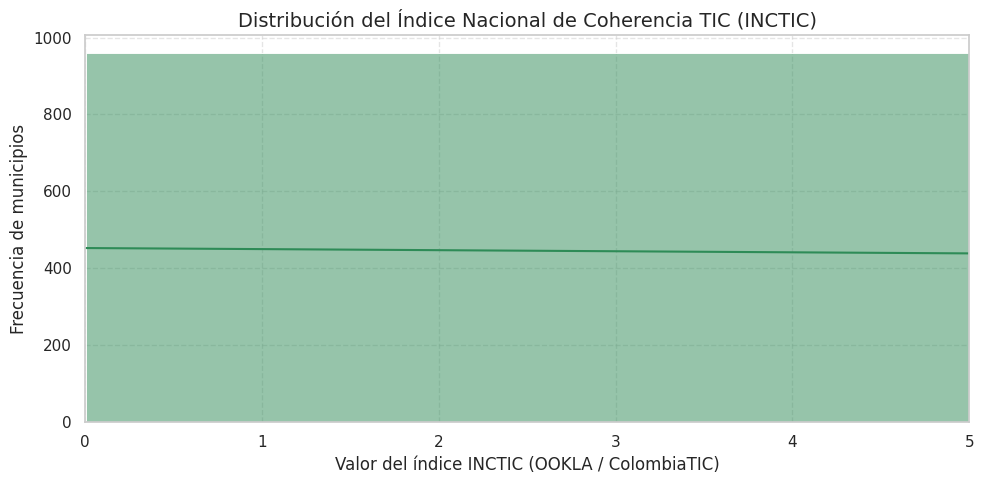

,Promedio,Mediana,Municipios
DEPARTAMENTO_N,,,
VAUPES,544.527,1.664,3
GUAINIA,76.173,0.977,5
LA GUAJIRA,29.067,0.441,15
CUNDINAMARCA,21.557,0.585,114
TOLIMA,19.177,1.166,46
NORTE DE SANTANDER,18.145,1.078,39
META,17.332,1.953,27
BOYACA,16.625,1.141,121
NARINO,12.335,0.787,54


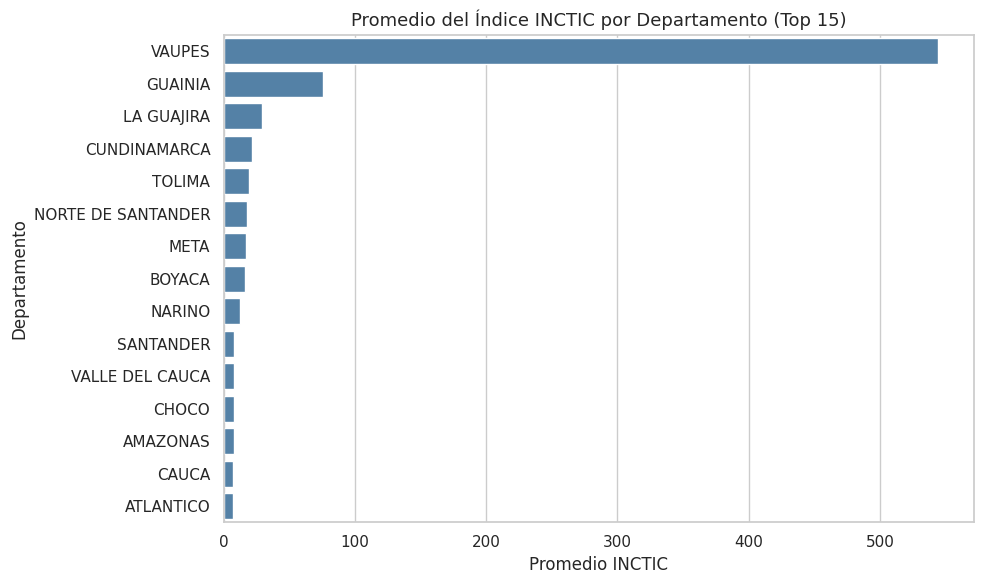

⚠️ No se pudo generar el mapa: /content/gdrive/MyDrive/trabajoGrado/ookla_datos/shapes/departamentos.geojson: No such file or directory
💾 Resumen departamental guardado en: /content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resumen_departamental_inctic.csv


In [ ]:
# ------------------------------------------------------------
# 🎨 Visualización del Índice Nacional de Coherencia TIC (INCTIC)
# ------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np

# --- Ruta del archivo generado ---
ruta_inctic = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resultado_inctic.csv"

# --- Cargar los resultados del índice ---
df = pd.read_csv(ruta_inctic)
print(f"✅ Registros cargados: {len(df):,}")

# --- Configuración visual ---
sns.set(style="whitegrid", palette="viridis", font_scale=1.0)

# ------------------------------------------------------------
# 📊 Distribución general del INCTIC
# ------------------------------------------------------------
plt.figure(figsize=(10,5))
sns.histplot(df["INCTIC"], bins=80, color="#2E8B57", kde=True)
plt.title("Distribución del Índice Nacional de Coherencia TIC (INCTIC)", fontsize=14)
plt.xlabel("Valor del índice INCTIC (OOKLA / ColombiaTIC)")
plt.ylabel("Frecuencia de municipios")
plt.xlim(0, 5)  # recorta valores extremos para una lectura más clara
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 🏛️ Coherencia promedio por departamento
# ------------------------------------------------------------
resumen_dep = (
    df.groupby("DEPARTAMENTO_N")["INCTIC"]
    .agg(["mean", "median", "count"])
    .rename(columns={"mean": "Promedio", "median": "Mediana", "count": "Municipios"})
    .round(3)
    .sort_values("Promedio", ascending=False)
)
display(resumen_dep.head(15))

plt.figure(figsize=(10,6))
sns.barplot(
    data=resumen_dep.reset_index().sort_values("Promedio", ascending=False).head(15),
    x="Promedio", y="DEPARTAMENTO_N", color="#4682B4"
)
plt.title("Promedio del Índice INCTIC por Departamento (Top 15)", fontsize=13)
plt.xlabel("Promedio INCTIC")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 🗺️ Mapa de coherencia (requiere shapefile de departamentos)
# ------------------------------------------------------------
try:
    # Ruta al shapefile nacional (puede ser el de tu carpeta /shapes)
    shape_path = "/content/gdrive/MyDrive/trabajoGrado/ookla_datos/shapes/departamentos.geojson"
    gdf = gpd.read_file(shape_path)

    # Normalizar nombres de departamentos
    gdf["NOMBRE_DPT"] = gdf["NOMBRE_DPT"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # Combinar con el resumen
    gdf = gdf.merge(resumen_dep, left_on="NOMBRE_DPT", right_on="DEPARTAMENTO_N", how="left")

    # Graficar
    plt.figure(figsize=(10, 10))
    gdf.plot(column="Promedio", cmap="YlGnBu", linewidth=0.5, edgecolor="gray", legend=True)
    plt.title("Mapa de coherencia promedio del INCTIC por departamento", fontsize=14)
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"⚠️ No se pudo generar el mapa: {e}")

# ------------------------------------------------------------
# 📤 Exportar resumen para informe
# ------------------------------------------------------------
ruta_resumen = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resumen_departamental_inctic.csv"
resumen_dep.to_csv(ruta_resumen)
print(f"💾 Resumen departamental guardado en: {ruta_resumen}")


Bloque de código — Resultados por departamento (sin outliers)

✅ Registros originales: 1,054
✅ Registros después del filtro: 782

📈 Estadísticas generales sin outliers:
   Registros válidos: 782
   Promedio INCTIC: 0.689
   Mediana INCTIC: 0.407
   Desviación estándar: 0.727
   Mínimo: 0.005
   Máximo: 2.971


,Promedio,Mediana,Municipios
DEPARTAMENTO_N,,,
VAUPES,1.481,1.481,2
AMAZONAS,1.072,0.773,4
CORDOBA,0.988,0.758,23
ARAUCA,0.919,0.690,7
META,0.904,0.543,17
ATLANTICO,0.878,0.692,17
BOYACA,0.869,0.502,88
CAUCA,0.867,0.515,20
MAGDALENA,0.812,0.539,25


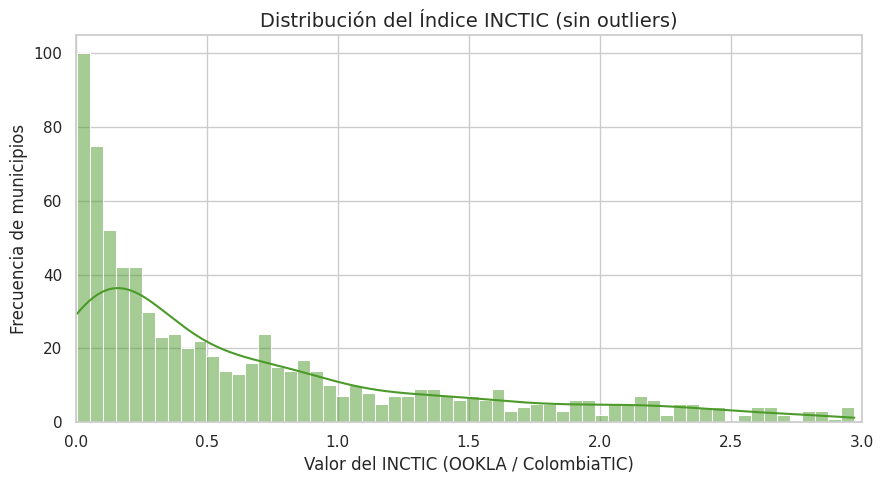

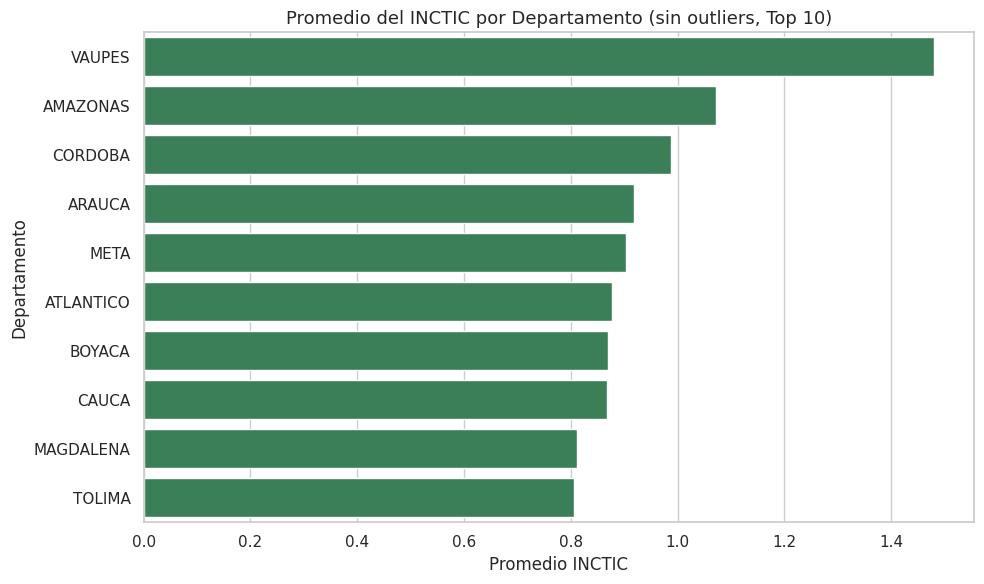

💾 Resumen departamental limpio guardado en: /content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resumen_inctic_sin_outliers.csv


In [ ]:
# ============================================================
# 📊 Análisis departamental sin outliers (INCTIC ≤ 3)
# ============================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Cargar resultados ---
ruta_inctic = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resultado_inctic.csv"
df = pd.read_csv(ruta_inctic)

# --- Filtrar outliers ---
df_filtrado = df[df["INCTIC"] <= 3].copy()
print(f"✅ Registros originales: {len(df):,}")
print(f"✅ Registros después del filtro: {len(df_filtrado):,}")

# --- Estadísticas generales ---
estadisticas = {
    "Registros válidos": len(df_filtrado),
    "Promedio INCTIC": round(df_filtrado["INCTIC"].mean(), 3),
    "Mediana INCTIC": round(df_filtrado["INCTIC"].median(), 3),
    "Desviación estándar": round(df_filtrado["INCTIC"].std(), 3),
    "Mínimo": round(df_filtrado["INCTIC"].min(), 3),
    "Máximo": round(df_filtrado["INCTIC"].max(), 3),
}
print("\n📈 Estadísticas generales sin outliers:")
for k, v in estadisticas.items():
    print(f"   {k}: {v}")

# --- Promedios por departamento ---
resumen_dep = (
    df_filtrado.groupby("DEPARTAMENTO_N")["INCTIC"]
    .agg(["mean", "median", "count"])
    .rename(columns={"mean": "Promedio", "median": "Mediana", "count": "Municipios"})
    .round(3)
    .sort_values("Promedio", ascending=False)
)
display(resumen_dep.head(15))

# --- Gráfico: Distribución general ---
sns.set(style="whitegrid", palette="crest", font_scale=1.0)
plt.figure(figsize=(9,5))
sns.histplot(df_filtrado["INCTIC"], bins=60, kde=True, color="#4C9A2A")
plt.title("Distribución del Índice INCTIC (sin outliers)", fontsize=14)
plt.xlabel("Valor del INCTIC (OOKLA / ColombiaTIC)")
plt.ylabel("Frecuencia de municipios")
plt.xlim(0, 3)
plt.tight_layout()
plt.show()

# --- Gráfico: Promedio departamental (Top 10) ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=resumen_dep.reset_index().head(10),
    x="Promedio", y="DEPARTAMENTO_N", color="#2E8B57"
)
plt.title("Promedio del INCTIC por Departamento (sin outliers, Top 10)", fontsize=13)
plt.xlabel("Promedio INCTIC")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

# --- Exportar resultados limpios ---
ruta_salida = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resumen_inctic_sin_outliers.csv"
resumen_dep.to_csv(ruta_salida)
print(f"💾 Resumen departamental limpio guardado en: {ruta_salida}")


Bloque 4.5: Análisis de correlación entre velocidades Ookla y ColombiaTIC

✅ Registros válidos para análisis: 787

📊 Coeficientes de correlación de Pearson:
   🔹 Subida  -> r = 0.149
   🔹 Bajada  -> r = 0.137


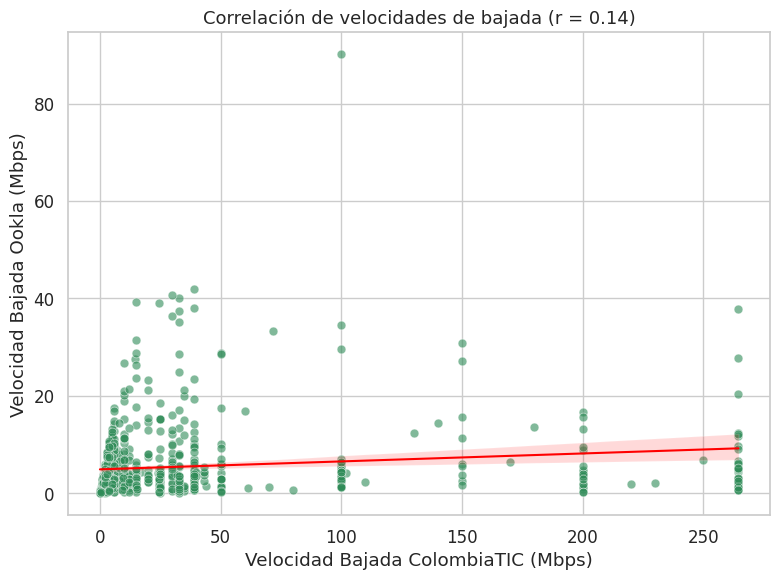

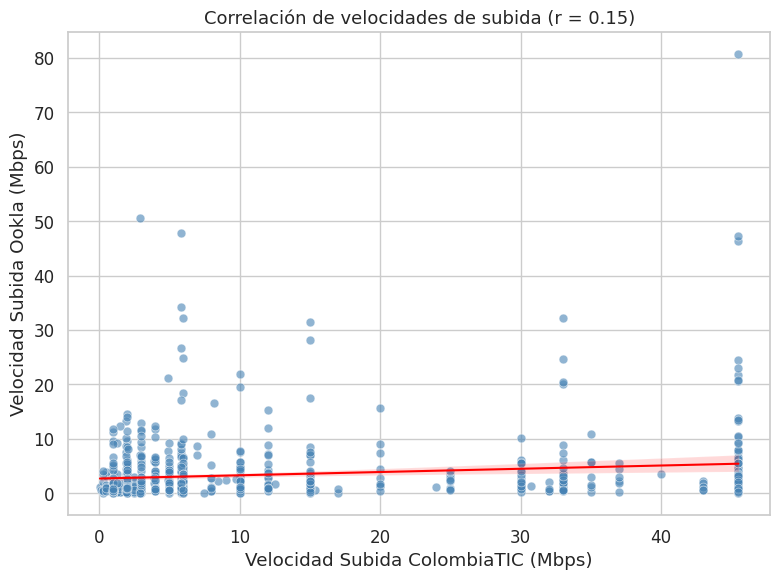


💾 Resumen de correlaciones guardado en: /content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resumen_correlacion_inctic.csv


,Tipo,Correlación (r de Pearson)
0,Subida,0.149
1,Bajada,0.137


In [ ]:
# ============================================================
# 📈 4.5. Análisis de correlación entre velocidades Ookla y ColombiaTIC
# ============================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- Cargar cruce base (ya limpio) ---
ruta_cruce = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/cruce_tic_ookla_temp.csv"
df = pd.read_csv(ruta_cruce)

# --- Filtrar outliers extremos (basado en INCTIC <= 3) ---
df["INCTIC"] = df["vel_bajada_ookla"] / df["vel_bajada_tic"]
df_filtrado = df[(df["INCTIC"] <= 3) & (df["vel_bajada_tic"] > 0) & (df["vel_bajada_ookla"] > 0)]

print(f"✅ Registros válidos para análisis: {len(df_filtrado):,}")

# --- Calcular correlaciones Pearson ---
corr_subida, _ = pearsonr(df_filtrado["vel_subida_tic"], df_filtrado["vel_subida_ookla"])
corr_bajada, _ = pearsonr(df_filtrado["vel_bajada_tic"], df_filtrado["vel_bajada_ookla"])

print("\n📊 Coeficientes de correlación de Pearson:")
print(f"   🔹 Subida  -> r = {corr_subida:.3f}")
print(f"   🔹 Bajada  -> r = {corr_bajada:.3f}")

# --- Gráfico: correlación de velocidades de bajada ---
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_filtrado.sample(min(1000, len(df_filtrado))),  # muestra si la base es grande
    x="vel_bajada_tic", y="vel_bajada_ookla",
    alpha=0.6, s=40, color="#2E8B57"
)
sns.regplot(
    data=df_filtrado,
    x="vel_bajada_tic", y="vel_bajada_ookla",
    scatter=False, color="red", line_kws={"linewidth":1.5}
)
plt.title(f"Correlación de velocidades de bajada (r = {corr_bajada:.2f})", fontsize=13)
plt.xlabel("Velocidad Bajada ColombiaTIC (Mbps)")
plt.ylabel("Velocidad Bajada Ookla (Mbps)")
plt.tight_layout()
plt.show()

# --- Gráfico: correlación de velocidades de subida ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_filtrado.sample(min(1000, len(df_filtrado))),
    x="vel_subida_tic", y="vel_subida_ookla",
    alpha=0.6, s=40, color="#4682B4"
)
sns.regplot(
    data=df_filtrado,
    x="vel_subida_tic", y="vel_subida_ookla",
    scatter=False, color="red", line_kws={"linewidth":1.5}
)
plt.title(f"Correlación de velocidades de subida (r = {corr_subida:.2f})", fontsize=13)
plt.xlabel("Velocidad Subida ColombiaTIC (Mbps)")
plt.ylabel("Velocidad Subida Ookla (Mbps)")
plt.tight_layout()
plt.show()

# --- Exportar correlaciones ---
resumen_corr = pd.DataFrame({
    "Tipo": ["Subida", "Bajada"],
    "Correlación (r de Pearson)": [round(corr_subida, 3), round(corr_bajada, 3)]
})
ruta_corr = "/content/gdrive/MyDrive/trabajoGrado/colombiatic_datos/resumen_correlacion_inctic.csv"
resumen_corr.to_csv(ruta_corr, index=False)
print(f"\n💾 Resumen de correlaciones guardado en: {ruta_corr}")
display(resumen_corr)
